In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

df = pd.read_csv("all data/citizen/kerala.csv")

print(df["Species_name"].value_counts())

df = df[df["Species_name"] == "Mango (all varieties)-Mangifera indica"]
df = df[df["Year"] == 2023]
df = df.drop(["Date_of_observation", "Observation_ID", "User_id", "User_Tree_id", "Species_id", "State_name", "Species_name", "Year"], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)

weeks = df["Week"]
df

Species_name
Mango (all varieties)-Mangifera indica          41613
Jackfruit-Artocarpus heterophyllus              39176
Coconut palm-Cocos nucifera                     14213
Tamarind-Tamarindus indica                      13992
Indian Laburnum-Cassia fistula                  12320
                                                ...  
Meethabhaji-Champereia manillana                    1
Chinar-Platanus Orientalis                          1
Himalayan Rhododendron-Rhododendron arboreum        1
Duabanga-Duabanga grandiflora                       1
Broken Bones Tree-Oroxylum Indicum                  1
Name: count, Length: 153, dtype: int64


,Lat,Long,Leaves_fresh,Leaves_mature,Leaves_old,Flowers_bud,Flowers_open,Flowers_male,Flowers_Female,Fruits_unripe,Fruits_ripe,Fruits_open,Week
0,10.77145,76.48380,1.0,2.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,42
1,11.86728,75.37995,2.0,2.0,1.0,1.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,40
2,11.75091,75.49266,1.0,2.0,1.0,2.0,2.0,-2.0,-2.0,2.0,0.0,-2.0,42
3,10.13695,76.52394,2.0,1.0,1.0,1.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,39
4,9.98534,76.77693,2.0,2.0,1.0,1.0,1.0,-2.0,-2.0,2.0,1.0,-2.0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442,8.80151,76.76254,1.0,2.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,22
6443,8.79411,76.75868,1.0,2.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,22
6444,8.79411,76.75868,1.0,2.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,21
6445,8.80151,76.76254,1.0,2.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,21


In [15]:
model = IsolationForest(n_estimators = 500, verbose = 1, random_state = 42)

data = {}
cent = {}

for week in weeks.unique():
    print(f"Week {week}")
    week_df = df[df["Week"] == week]
    
    week_df.drop("Week", axis=1)
    week_df = week_df.reset_index(drop=True)
    
    model.fit(week_df)
    preds = model.predict(week_df)
    
    week_df["Predictions"] = preds
    
    valid_data = week_df[week_df["Predictions"] == 1]
    valid_data = valid_data.reset_index(drop=True)
    
    km = KMeans(n_clusters=1, random_state=42, n_init="auto")
    clusters = km.fit_predict(valid_data)
    
    d = []
    
    centroids = km.cluster_centers_

    for i, row in valid_data.iterrows():
        cluster_label = clusters[i]
        centroid = centroids[0]
        relevant_values = row.values
        float_centroid = [float(val) for val in centroid]
        distance = np.linalg.norm(relevant_values - float_centroid)
        d.append(distance)
    
    valid_data['Distance_to_Centroid'] = d
    closest_point = valid_data[ valid_data["Distance_to_Centroid"] == min(valid_data['Distance_to_Centroid']) ]
    print(f"Week {week} reference: {closest_point.iloc[0]}")
    cent[week] = km.cluster_centers_
    data[week] = closest_point.iloc[0]

Week 42
Week 42 reference: Lat                     10.162890
Long                    76.513750
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Week                    42.000000
Predictions              1.000000
Distance_to_Centroid     0.552628
Name: 90, dtype: float64
Week 40
Week 40 reference: Lat                     10.162890
Long                    76.513750
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Wee

Week 21 reference: Lat                      9.397710
Long                    76.578530
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                    21.000000
Predictions              1.000000
Distance_to_Centroid     1.034301
Name: 8, dtype: float64
Week 27
Week 27 reference: Lat                     10.120980
Long                    76.396180
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Week        

Week 18 reference: Lat                     10.818530
Long                    76.672830
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                    18.000000
Predictions              1.000000
Distance_to_Centroid     0.785576
Name: 63, dtype: float64
Week 17
Week 17 reference: Lat                     10.818530
Long                    76.672810
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week       

Week 3 reference: Lat                      9.613680
Long                    76.532790
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              2.000000
Flowers_open             2.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Week                     3.000000
Predictions              1.000000
Distance_to_Centroid     0.965124
Name: 42, dtype: float64
Week 2
Week 2 reference: Lat                     10.818530
Long                    76.672830
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              1.000000
Flowers_open             1.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Week          

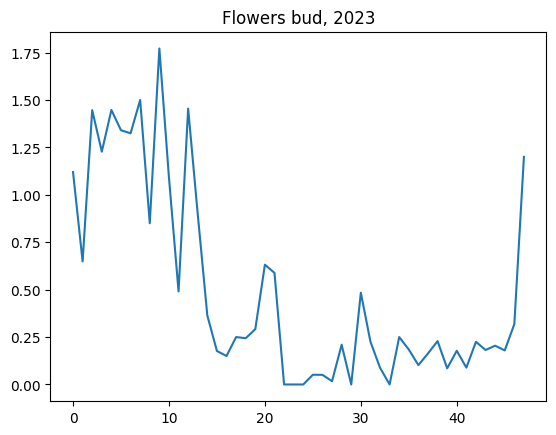

In [22]:
time = np.arange(0, 48)
flowers_bud = []

for i in range(48):
    flowers_bud.append(cent[i][0][3])

plt.plot(time, flowers_bud)
plt.title("Flowers bud, 2023")
plt.show()

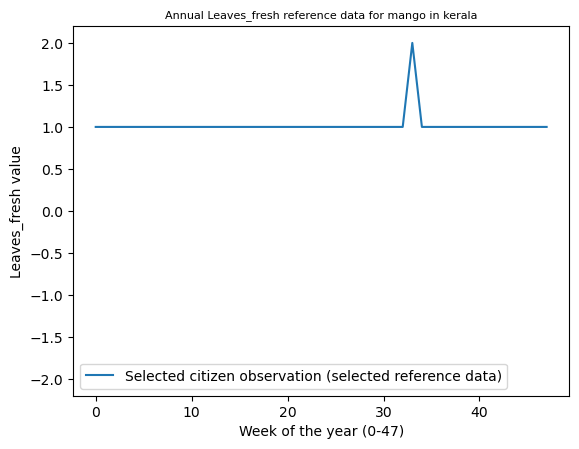

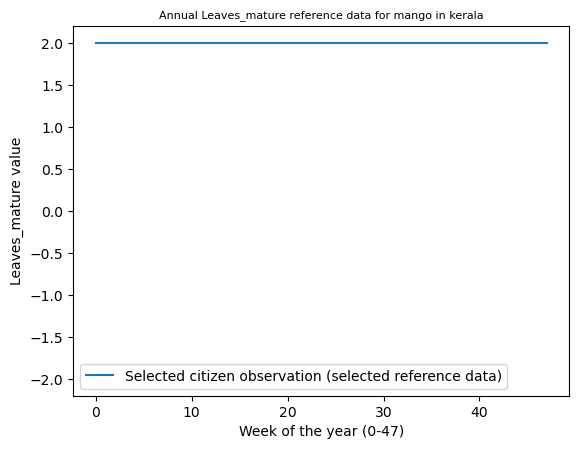

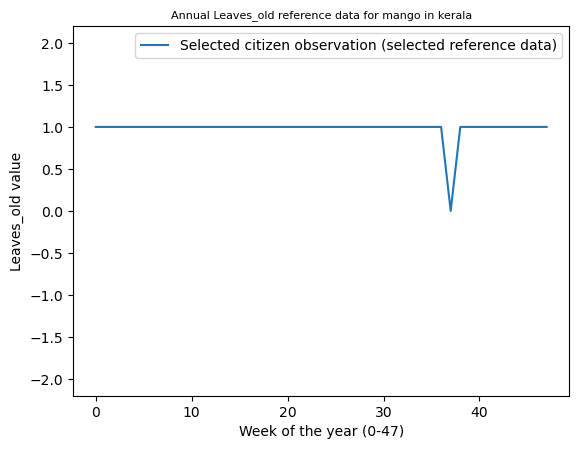

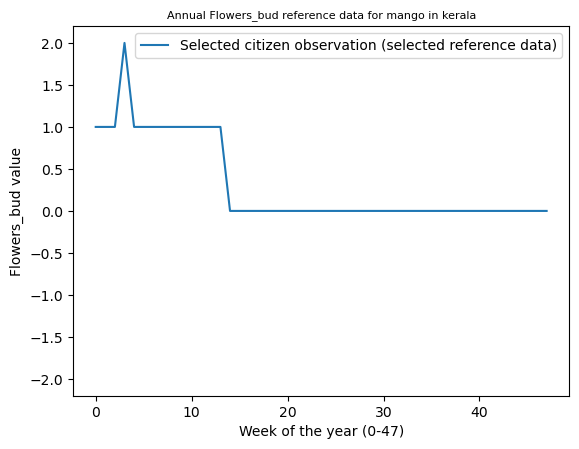

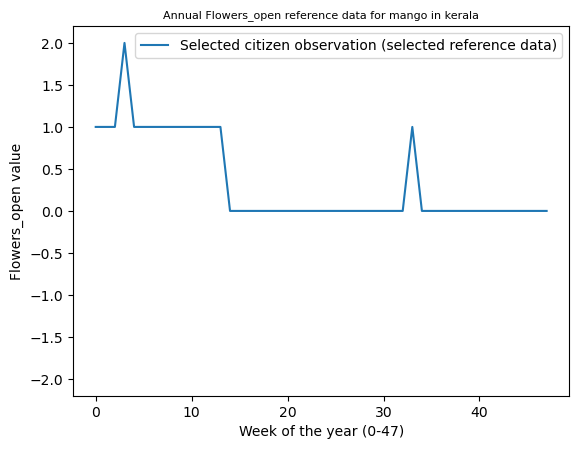

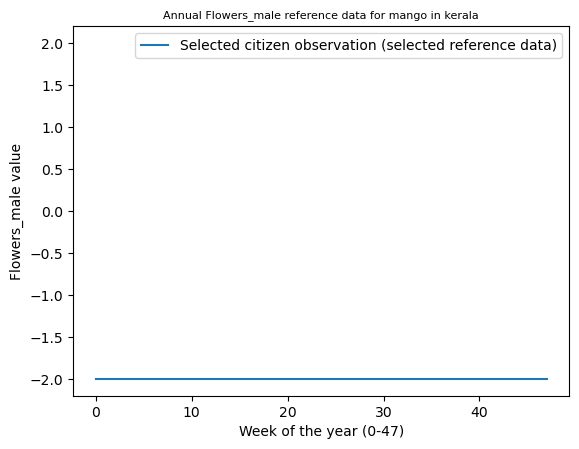

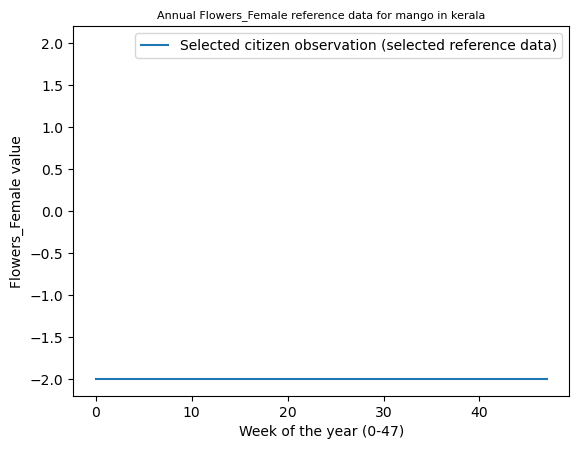

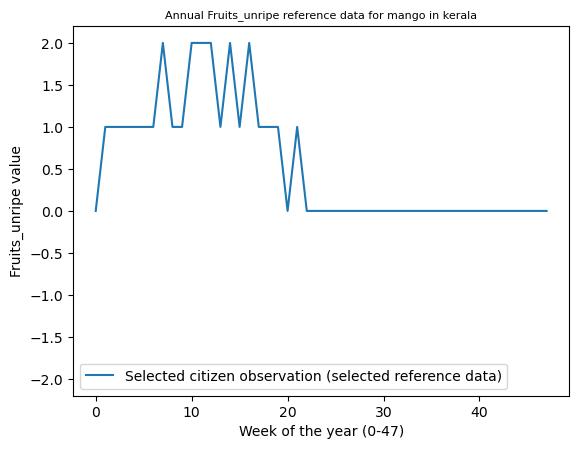

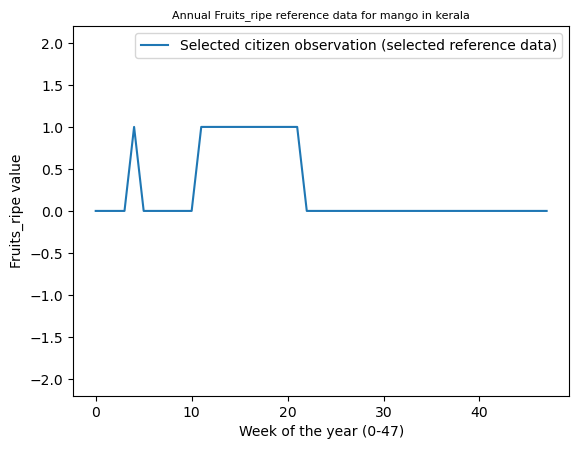

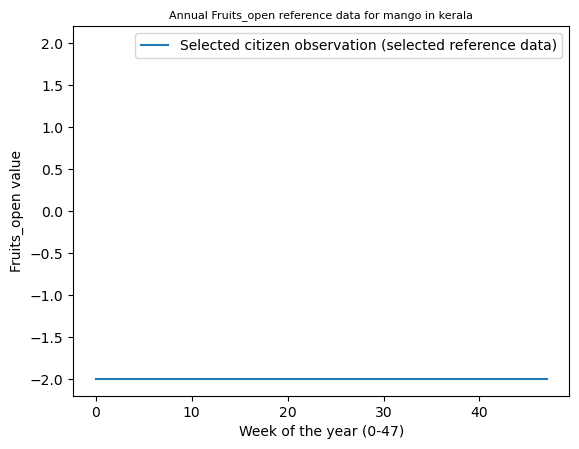

In [16]:
#os.makedirs(f"{plot_path}/{state}", exist_ok=True)

phenophases = ['Leaves_fresh','Leaves_mature','Leaves_old','Flowers_bud','Flowers_open',
               'Flowers_male','Flowers_Female','Fruits_unripe','Fruits_ripe','Fruits_open']
for phenophase in phenophases:
    #os.makedirs(f"{plot_path}/{state}", exist_ok=True)
    x = list(range(48))
    y = [data[week][phenophase] for week in range(48)]

    plt.plot(x, y, label=f'Selected citizen observation (selected reference data)')
    plt.xlabel('Week of the year (0-47)')
    plt.ylabel(f'{phenophase} value')
    plt.ylim(-2.2,2.2)
    #plt.title(f'Annual {phenophase} reference data for {species} in {state}', fontsize=8)
    plt.title(f'Annual {phenophase} reference data for mango in kerala', fontsize=8)
    plt.legend()
    plt.show()
    #plt.savefig(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}_{transition_attr}_{year}")
    #plt.close()